In [235]:
# Third-party packages
import numpy as np, os, xarray as xr, pandas as pd
import cartopy, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as pltzz
# Custom packages
import tc_analysis, utilities

#### Data access

In [320]:
model, experiment = 'HIRAM', 'control'
raw = tc_analysis.tc_model_data(models=[model], experiments=[experiment], storm_type='C15w', num_storms=1)
data = raw[model][experiment]['data'][0]

	 Storms to be processed: ['2053-0010']
	 	 Processing 2053-0010 from /projects/GEOCLIM/gr7610/analysis/tc_storage/individual_TCs/processed/TC-HIRAM-control-C15w-2053-0010-max_wind-47-min_slp-931.pkl


#### Plot storm location

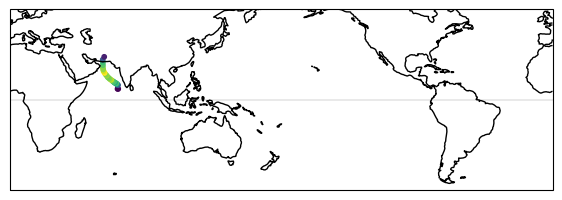

In [321]:
proj, proj_ref = ccrs.PlateCarree(central_longitude=180), ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': proj})
ax.scatter(data['track_output']['center_lon'], data['track_output']['center_lat'], s=10, c=data['track_output']['max_wind'],
           transform=proj_ref)
ax.axhline(0, c='k', lw=0.25, alpha=0.5)
ax.coastlines()
ax.set_extent([0, 359, -60, 60])

#### Get timestamp at LMI

In [322]:
n_days = 0
# Get Pandas-friendly timestamps for DataFrame indexing
timestamps = [utilities.time_adjust(model, t, method='cftime_to_pandas') 
              for t in data['tc_vertical_output'].time.values if not ((t.month == 2) & (t.day == 29))] 
# Get strongest timestamp
timestamp_lmi = data['track_output'].loc[data['track_output']['time'].isin(timestamps)].sort_values('max_wind', ascending=False).iloc[0]['time'] 
# Get the timestamps found from +/- n_days and revert to cftime for DataArray indexing
timestamp = [utilities.time_adjust(model, t, method='pandas_to_cftime') for t in timestamps 
              if abs(t - timestamp_lmi) <= pd.Timedelta(n_days, "d")][0]

#### Check raw wind fields
$U = \sqrt{u^2 + v^2}$, represented by the `wind` DataArray

Text(0.5, 0.98, 'HIRAM, control: 2053-0010, 0153-05-23 00:00:00')

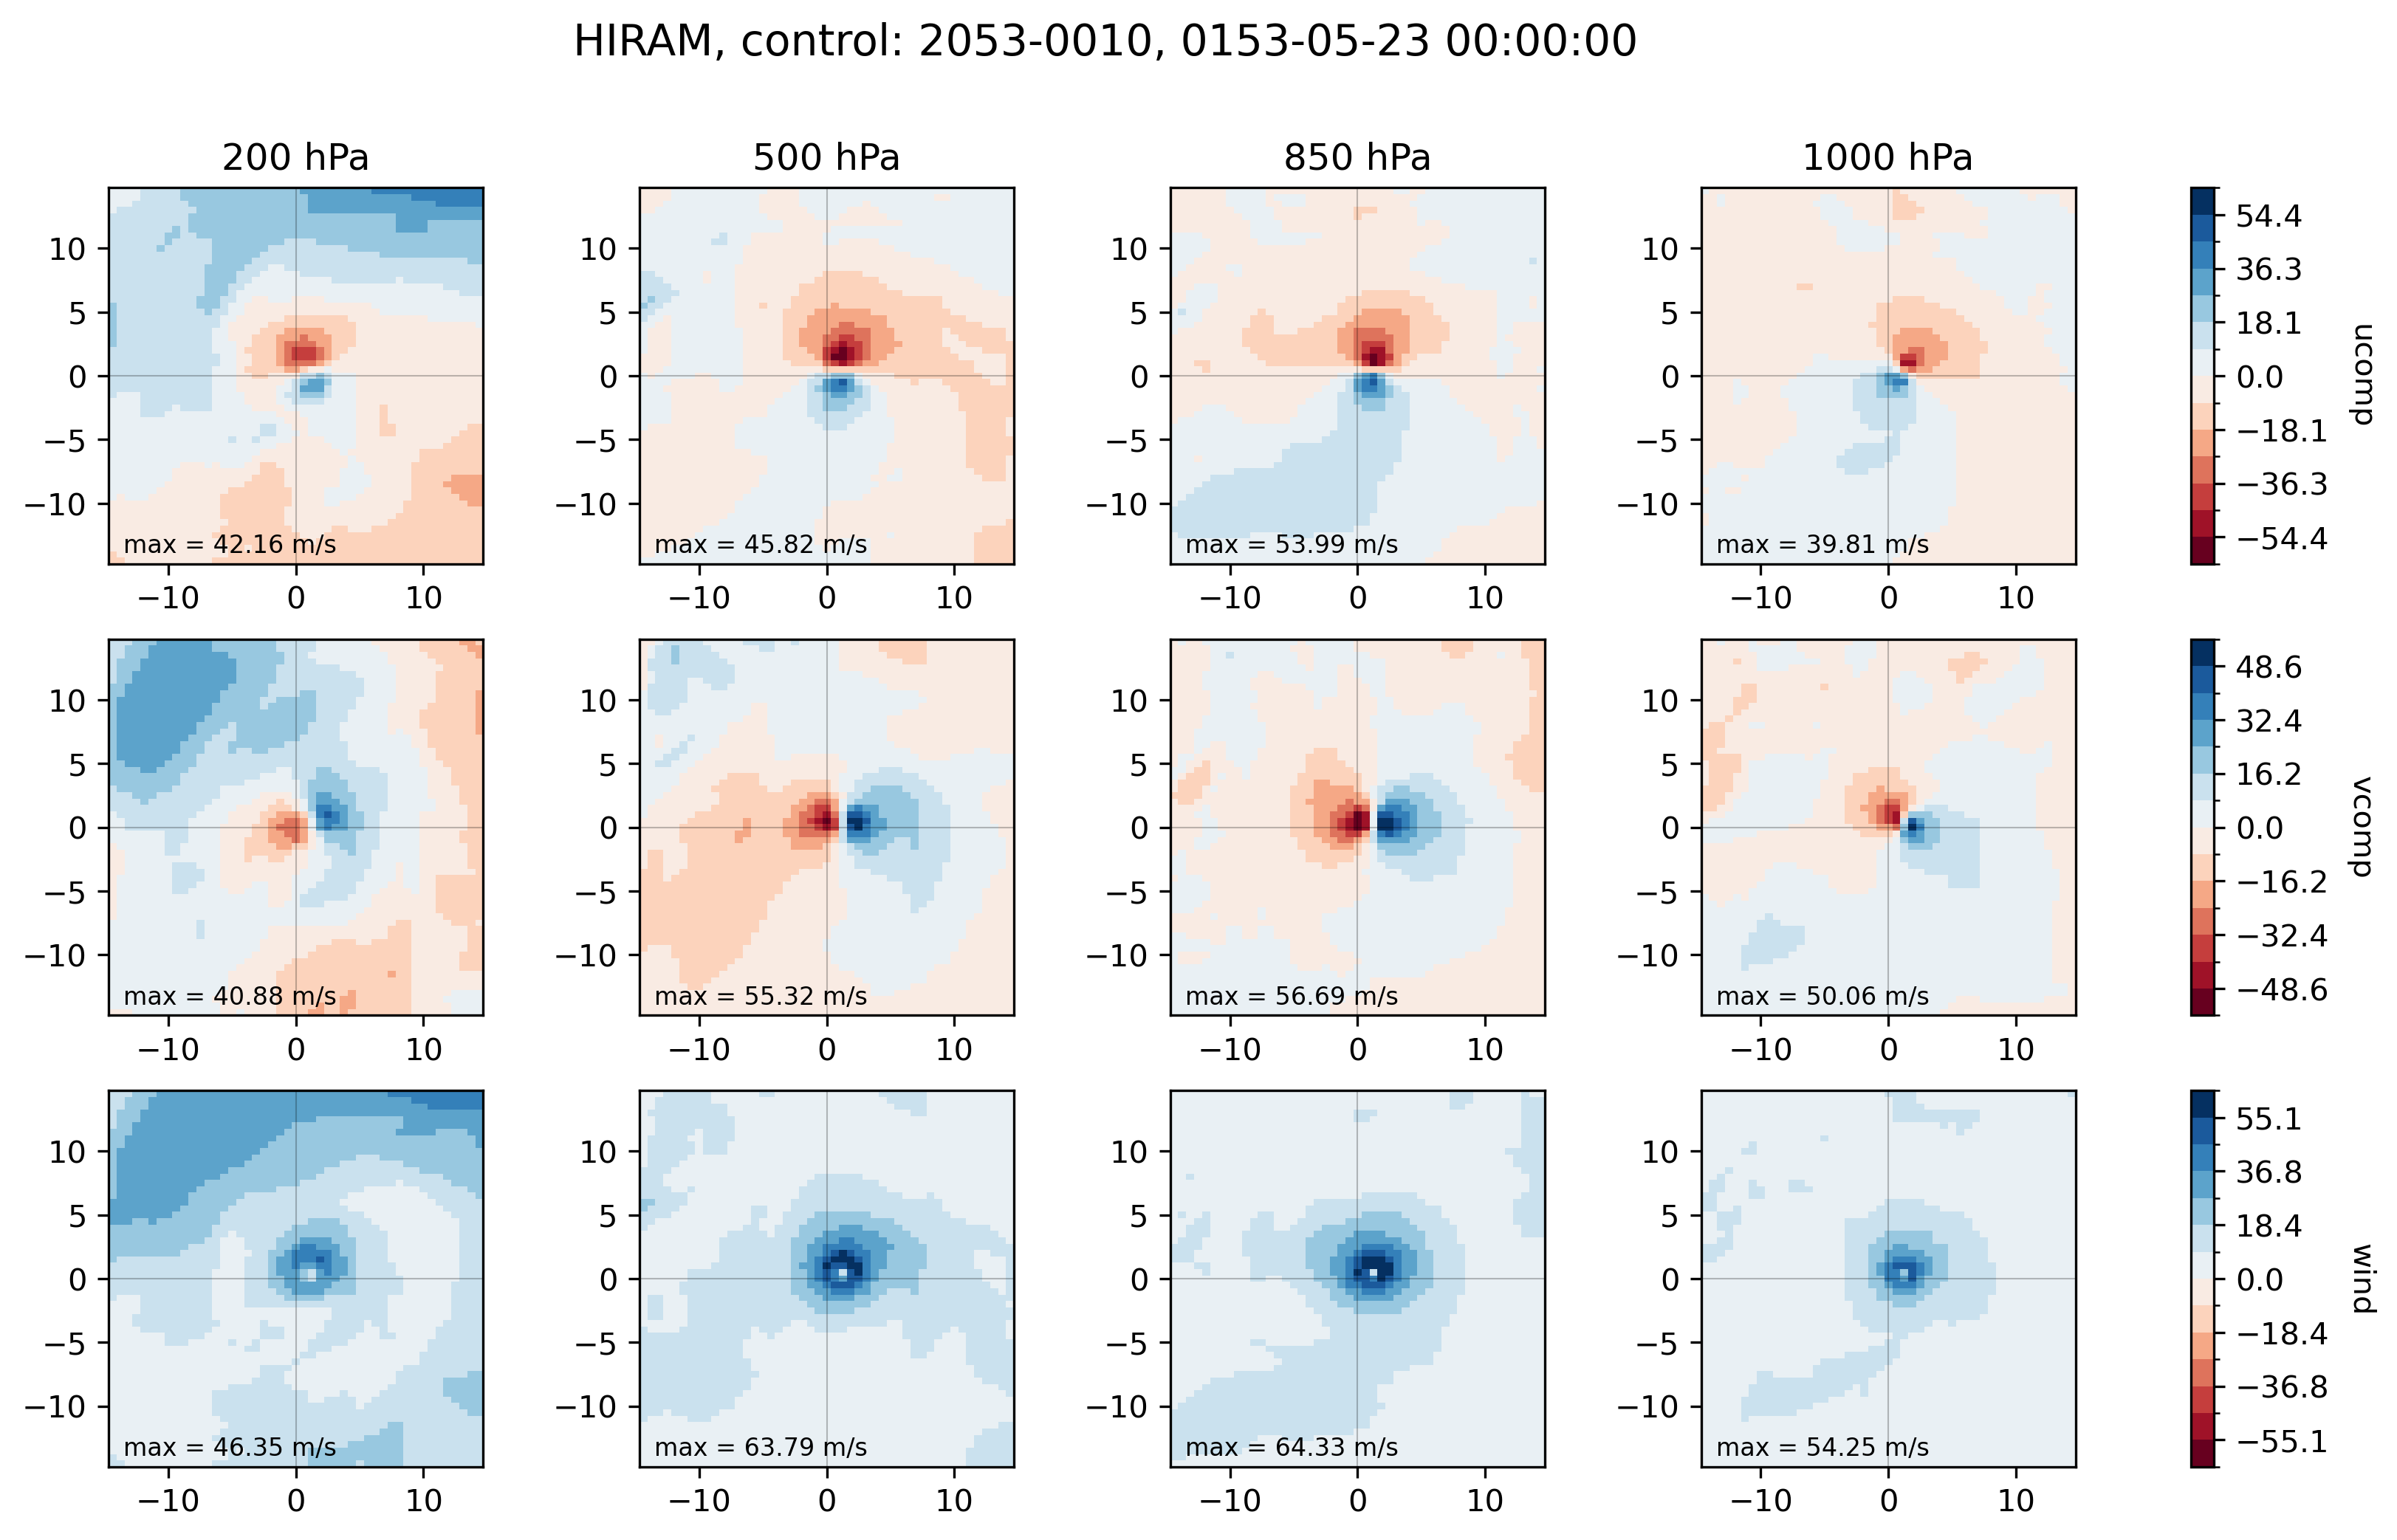

In [323]:
''' Data cleaning. '''
# Define data selection attributes
pressure_levels = [200, 500, 850, 1000] # vertical levels
time_index = 2 # time index
# Filter by time and clean data
dataset = data['tc_vertical_output'].sel(time=timestamp).dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all') 
# Filter out mean steering winds
for field in ['ucomp', 'vcomp']:
    dataset[field] = dataset[field] - dataset[field].sel(pfull=slice(200, 850)).mean(dim='grid_xt').mean(dim='grid_yt').mean(dim='pfull')
# Define fields to plot
fields = ['ucomp', 'vcomp']

''' Derived fields. '''
dataset['wind'] = np.sqrt(dataset['ucomp']**2 + dataset['vcomp']**2)
fields.append('wind')

''' Plot the figure. '''
# Initialize figure
nrows, ncols = len(fields), len(pressure_levels) + 1
fig, gs = [plt.figure(dpi=300, figsize=(ncols*2.5, nrows*2.5)), 
           matplotlib.gridspec.GridSpec(nrows=nrows, ncols=ncols, width_ratios=(1, 1, 1, 1, 0.05))]
# Iterate over velocity fields
for j, field in enumerate(fields):
    ''' Data normalization. '''
    vmin, vmax = [dataset[field].sel(pfull=pressure_levels, method='nearest').min(), 
                  dataset[field].sel(pfull=pressure_levels, method='nearest').max()]
    extremum = max([abs(vmin), abs(vmax)])
    norm, cmap = matplotlib.colors.BoundaryNorm(np.linspace(-extremum, extremum, 15), 256), 'RdBu'
    # Iterate over pressure levels
    for i in range(0, gs.ncols-1):
        # Set up subplot
        ax = fig.add_subplot(gs[j, i])
        ax.pcolormesh(dataset['TC_xt'], dataset['TC_yt'], dataset[field].sel(pfull=pressure_levels[i], method='nearest'), 
                      norm=norm, cmap=cmap)
        ax.axhline(0, c='k', lw=0.5, alpha=0.25)
        ax.axvline(0, c='k', lw=0.5, alpha=0.25)
        ax.set_aspect('equal')

        # Annotation
        ax.annotate('max = {0:.2f} m/s'.format(dataset[field].sel(pfull=pressure_levels[i], method='nearest').max()),
                    xy=(0.04, 0.03), xycoords='axes fraction', **{'fontsize': 8})

        if j == 0:
            ax.set_title('{0} hPa'.format(pressure_levels[i]))
    
    cax = fig.add_subplot(gs[j, -1])
    colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax)
    colorbar.set_label(field, rotation=270, labelpad=15)
    
fig.suptitle('{0}, {1}: {2}, {3}'.format(model, experiment, data['track_output']['storm_id'].unique().item(), dataset.time.values), fontsize=14)

#### Visualize geometric basis for the domain
X, Y grid and angle, $\theta$

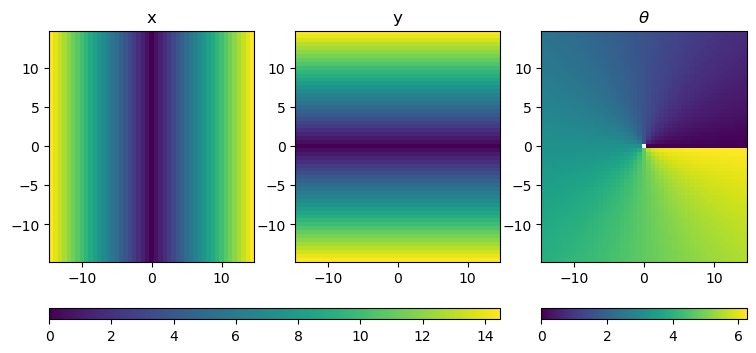

In [324]:
X, Y = np.meshgrid(abs(dataset['TC_xt']), abs(dataset['TC_yt']))
X_, Y_ = np.meshgrid(dataset['TC_xt'], dataset['TC_yt'])
theta = np.arctan(Y_/X_)
theta = np.where((X_ < 0) | (Y_ < 0), theta+np.pi, theta)
theta = np.where((X_ >= 0) & (Y_ < 0), theta+np.pi, theta)
fig, axes = plt.subplots(figsize=(9, 3), ncols=3)
axes[0].pcolormesh(dataset['TC_xt'], dataset['TC_yt'], X, cmap='viridis')
axes[0].set_title('x')
im = axes[1].pcolormesh(dataset['TC_xt'], dataset['TC_yt'], Y, cmap='viridis')
axes[1].set_title('y')
cax = axes[0].inset_axes([0, -0.25, 2.2, 0.05])
fig.colorbar(im, cax, orientation='horizontal')

im = axes[2].pcolormesh(dataset['TC_xt'], dataset['TC_yt'], theta, cmap='viridis')
axes[2].set_title('$\\theta$')
cax = axes[2].inset_axes([0, -0.25, 1, 0.05])
fig.colorbar(im, cax, orientation='horizontal')

#### Output radial and tangential winds using the preset data from above
$v_r = u\cos{\theta} + v\sin{\theta}$; $v_t = -u\sin{\theta} + v\cos{\theta}$

Text(0.5, 0.98, 'HIRAM, control: 2053-0010, 0153-05-23 00:00:00')

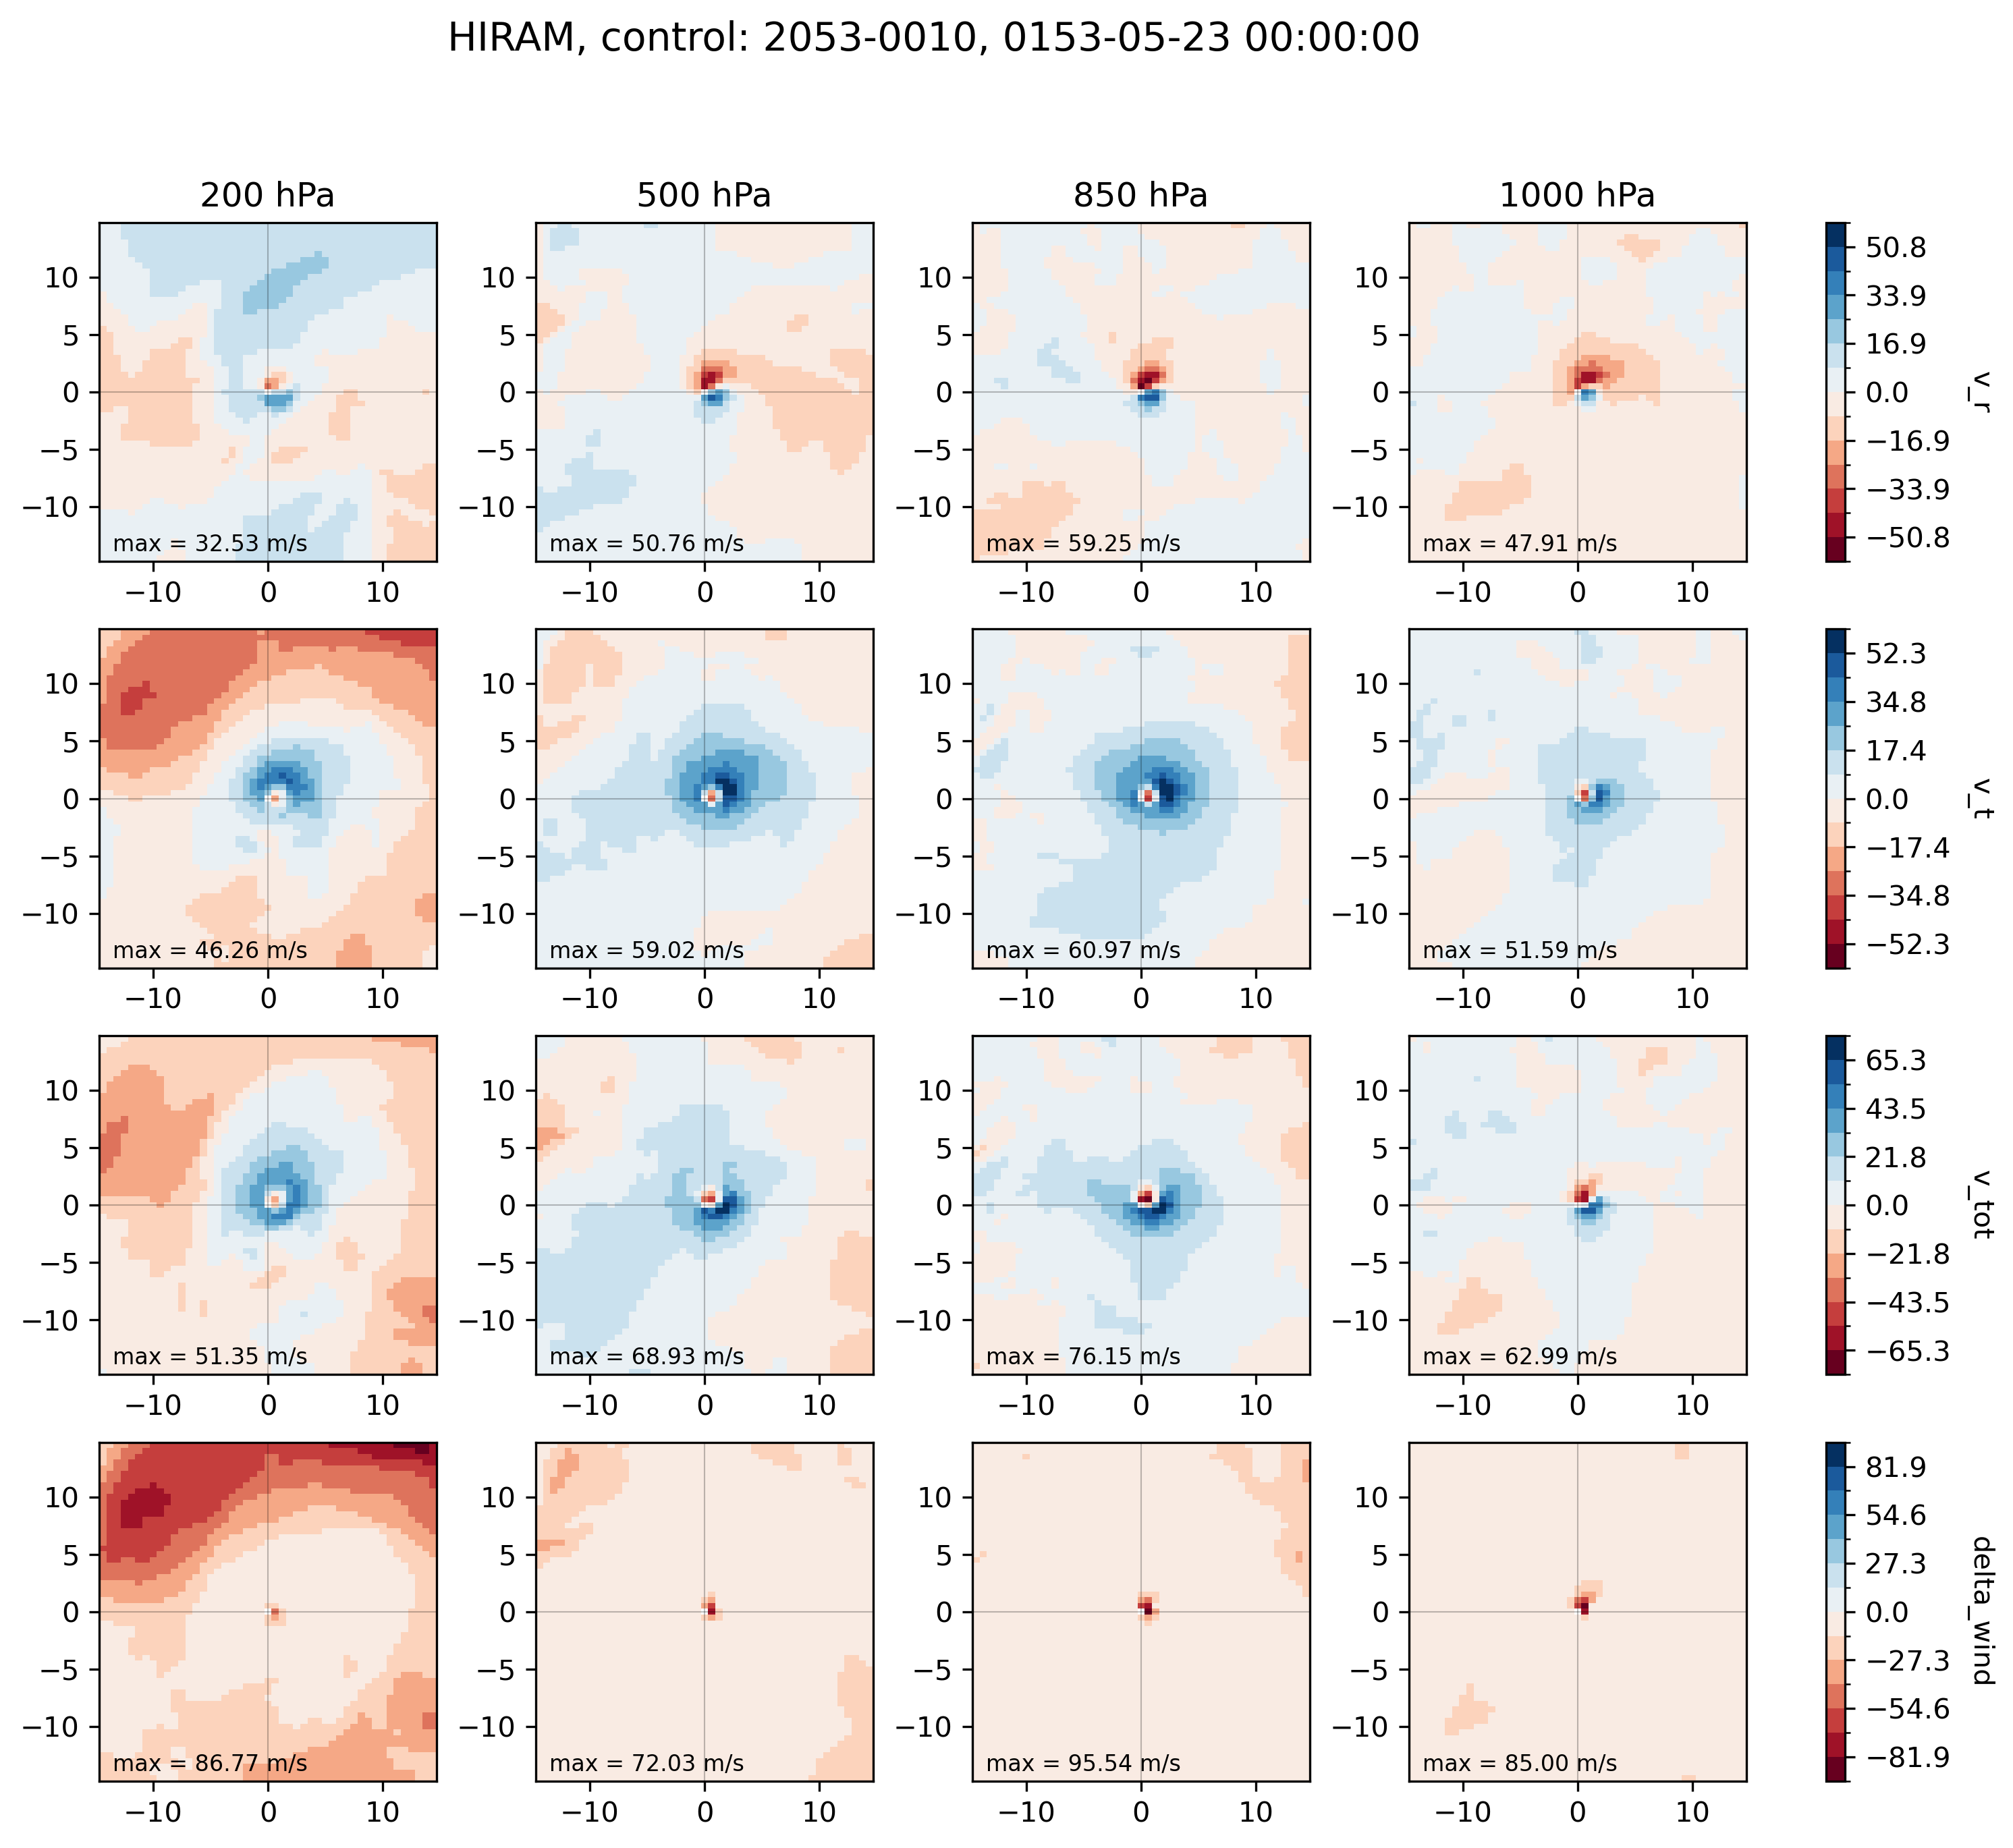

In [325]:
''' Derived fields. '''
dataset['v_r'] = dataset['ucomp']*np.cos(theta) + dataset['vcomp']*np.sin(theta) # radial component
dataset['v_t'] = -dataset['ucomp']*np.sin(theta) + dataset['vcomp']*np.cos(theta) # tangential component
dataset['v_tot'] = dataset['v_r'] + dataset['v_t'] # total wind vector
dataset['delta_wind'] = dataset['v_t'] - dataset['wind'] # Get difference with raw wind field
derived_wind_fields = ['v_r', 'v_t', 'v_tot', 'delta_wind']

''' Plot the figure. '''
# Initialize figure
nrows, ncols = len(derived_wind_fields), len(pressure_levels) + 1
fig, gs = [plt.figure(dpi=300, figsize=(ncols*2.25, nrows*2.5)), 
           matplotlib.gridspec.GridSpec(nrows=nrows, ncols=ncols, width_ratios=(1, 1, 1, 1, 0.05))]
# Iterate over velocity fields
for j, field in enumerate(derived_wind_fields):
    ''' Data normalization. '''
    vmin, vmax = [dataset[field].sel(pfull=pressure_levels, method='nearest').min(), 
                  dataset[field].sel(pfull=pressure_levels, method='nearest').max()]
    extremum = max([abs(vmin), abs(vmax)])
    norm, cmap = matplotlib.colors.BoundaryNorm(np.linspace(-extremum, extremum, 15), 256), 'RdBu'
    # Iterate over pressure levels
    for i in range(0, gs.ncols-1):
        # Set up subplot
        ax = fig.add_subplot(gs[j, i])
        ax.pcolormesh(dataset['TC_xt'], dataset['TC_yt'], dataset[field].sel(pfull=pressure_levels[i], method='nearest'), 
                      norm=norm, cmap=cmap)
        ax.axhline(0, c='k', lw=0.5, alpha=0.25)
        ax.axvline(0, c='k', lw=0.5, alpha=0.25)
        ax.set_aspect('equal')

        # Annotation
        ax.annotate('max = {0:.2f} m/s'.format(abs(dataset[field].sel(pfull=pressure_levels[i], method='nearest')).max()),
                    xy=(0.04, 0.03), xycoords='axes fraction', **{'fontsize': 8})

        if j == 0:
            ax.set_title('{0} hPa'.format(pressure_levels[i]))
    
    cax = fig.add_subplot(gs[j, -1])
    colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax)
    colorbar.set_label(field, rotation=270, labelpad=15)
    
fig.suptitle('{0}, {1}: {2}, {3}'.format(model, experiment, data['track_output']['storm_id'].unique().item(), dataset.time.values), fontsize=14)

#### Radial and tangential wind cross-sections at cardinal vectors

Text(0.5, 0.95, 'HIRAM, control: 2053-0010, 0153-05-23 00:00:00')

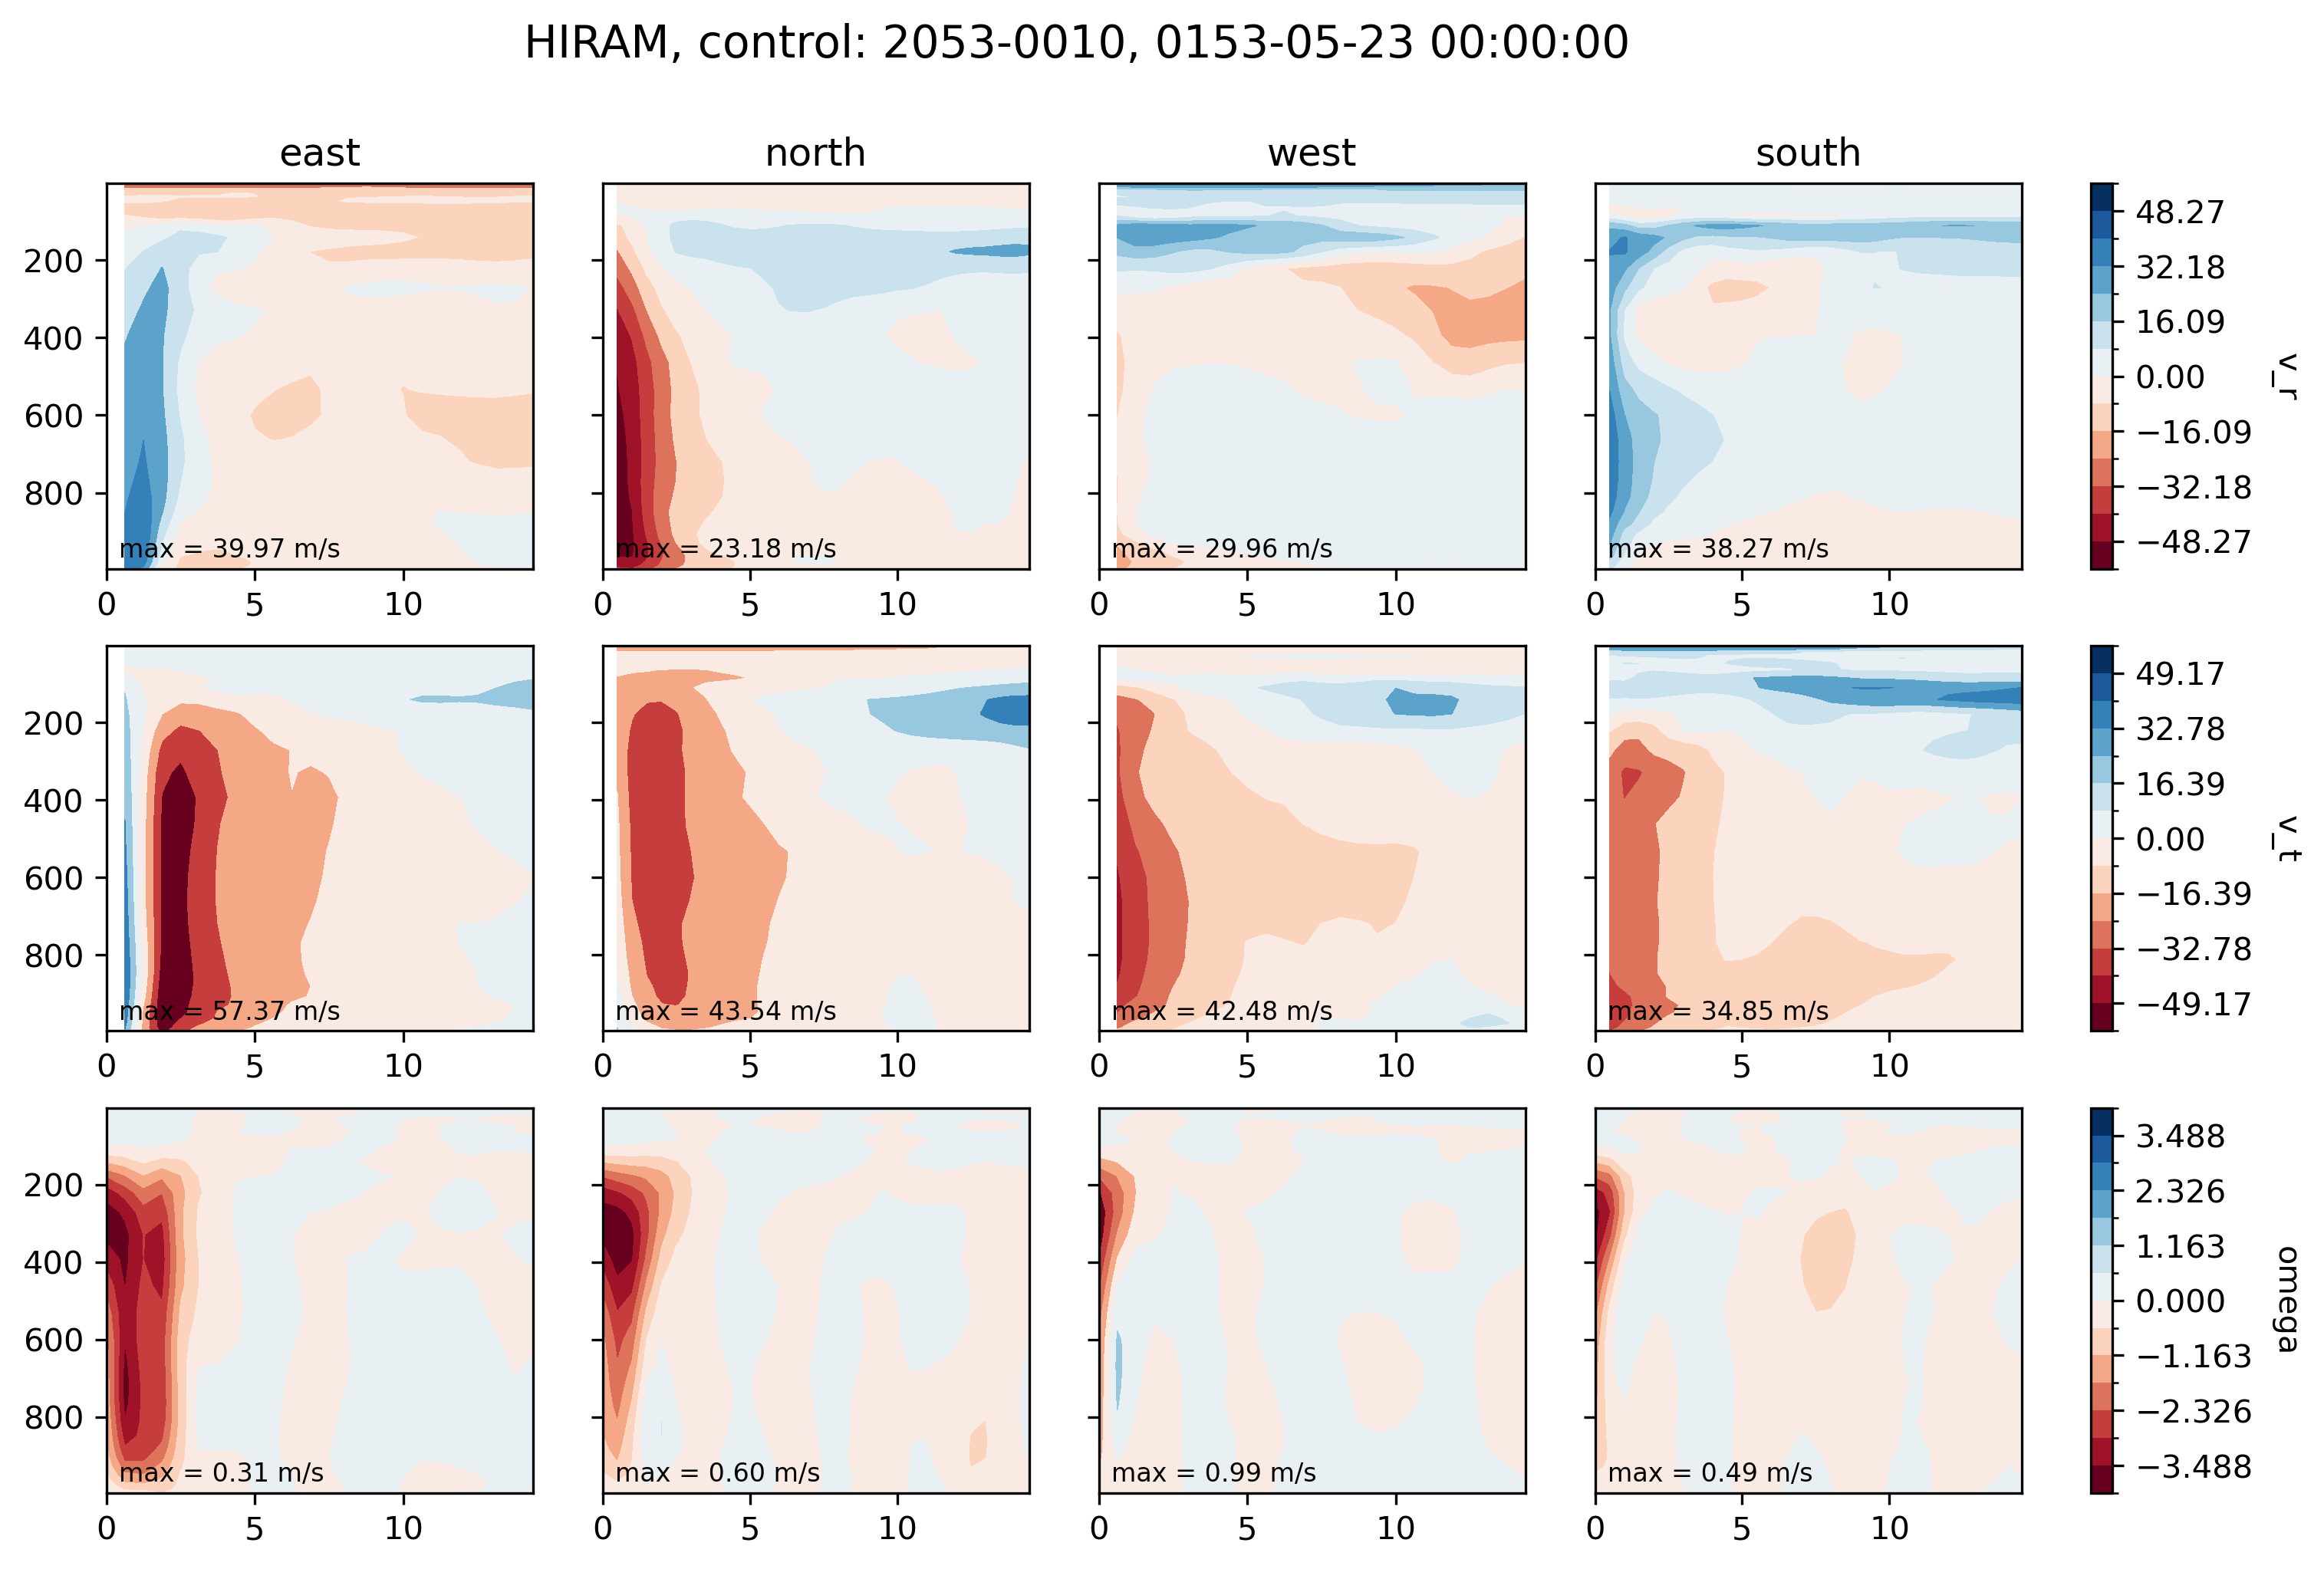

In [326]:
''' Derived fields. '''
# Get cardinal vectors
vectors = {'east': dataset.where((dataset['TC_xt'] >= 0) & (dataset['TC_yt'] == 0), drop=True).isel(grid_yt=0),
           'north': dataset.where((dataset['TC_xt'] == 0) & (dataset['TC_yt'] >= 0), drop=True).isel(grid_xt=0),
           'west': dataset.where((dataset['TC_xt'] <= 0) & (dataset['TC_yt'] == 0), drop=True).isel(grid_yt=0),
           'south': dataset.where((dataset['TC_xt'] == 0) & (dataset['TC_yt'] <= 0), drop=True).isel(grid_xt=0)}

''' Plot the figure. '''
# Initialize figure
nrows, ncols = len(derived_wind_fields), len(vectors.keys()) + 1
fig, gs = [plt.figure(dpi=300, figsize=(ncols*2.25, nrows*2.5)), 
           matplotlib.gridspec.GridSpec(nrows=nrows, ncols=ncols, width_ratios=(1, 1, 1, 1, 0.05))]
# Iterate over velocity fields
for j, field in enumerate(['v_r', 'v_t', 'omega']):
    ''' Data normalization. '''
    vmin, vmax = [max([abs(sv.max().item()) for k in vectors.keys() for sk, sv in vectors[k].items() if sk == field]), 
                  max([abs(sv.min().item()) for k in vectors.keys() for sk, sv in vectors[k].items() if sk == field])]
    extremum = max([vmin, vmax])
    norm, cmap = matplotlib.colors.BoundaryNorm(np.linspace(-extremum, extremum, 15), 256), 'RdBu'
    # Iterate over pressure levels
    for i, direction in enumerate(vectors.keys()):
        basis_vector = 'TC_xt' if direction in ['east', 'west'] else 'TC_yt'
        factor = -1 if field == 'v_t' else 1
        # Set up subplot
        ax = fig.add_subplot(gs[j, i])
        ax.contourf(abs(vectors[direction][basis_vector]), vectors[direction].pfull, factor*vectors[direction][field], 
                    norm=norm, cmap=cmap)
        ax.set_xlim([0, max(abs(vectors[direction][basis_vector]))])
        ax.set_ylim(ax.get_ylim()[::-1])

        # Annotation
        ax.annotate('max = {0:.2f} m/s'.format(abs(vectors[direction][field].max())),
                    xy=(0.03, 0.03), xycoords='axes fraction', **{'fontsize': 8})

        if i != 0:
            ax.set_yticklabels([])
        if j == 0:
            ax.set_title(direction)
    
    cax = fig.add_subplot(gs[j, -1])
    colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax)
    colorbar.set_label(field, rotation=270, labelpad=15)
    
fig.suptitle('{0}, {1}: {2}, {3}'.format(model, experiment, data['track_output']['storm_id'].unique().item(), dataset.time.values), 
             y=0.95, fontsize=14)

#### Azimuthal compositing method - check on existing data

Azimuthal compositing calculation

In [327]:
''' Methodology.
1. Create radius field from storm-centered coordinates.
2. Define grid resolution to define annular thickness.
3. Define the starting radius to initialize annulus
4. Create annular basis vector to determine where the annular radii will be defined.
5. Initialize output array, with dimensions of (pfull, basis_vector).
6. Create annulus, whose area will be averaged over.
7. Average over annular area.
8. Expand annulus by a grid cell and repeat 6-8 until domain edge is reached.
'''

# Initialize sample field for troubleshooting
field = 'wind_tangential'

# Initialize list to hold figures for future plotting for debugging
visuals = {}

# 1. Create radial field relative to storm center.
X, Y = np.meshgrid(dataset['TC_xt'], dataset['TC_yt'])
dataset['radius'] = xr.DataArray(data=np.sqrt(X**2 + Y**2), dims=('grid_yt', 'grid_xt'))
# 2. Define grid resolution from coarser of the two domain dimensions ('TC_xt' or 'TC_yt')
# Note: because the spatial extent is square, the dimension with fewer elements is coarser by definition
limiting_dimension = 'TC_xt' if len(dataset['TC_xt']) < len(dataset['TC_yt']) else 'TC_yt'
resolution = 1.5*np.diff(dataset[limiting_dimension])[0] # assume all elements are equal
# 3. Create the first annulus inner radius and the radial limit
r_i = 0
r_limit = dataset[limiting_dimension].max()
# 4. Create a basis vector over the radius to guide the annular expansion
rs = np.arange(r_i, r_limit + resolution, resolution)
# 5. Create output array
out = np.full(shape=(len(dataset.pfull.values), len(rs)-1), fill_value=np.nan)
# 6. Create the annulus using a loop based on the limiting dimension and resolution
# Note: use a basis vector from the center (0) to the domain edge
# Note: begin from index 1 to establish the outer annular radius
for index, r_o in enumerate(rs[1:]):
    # Uncomment to get metrics
    # print('Annulus #{0}: inner radius = {1:.2f}, outer radius = {2:.2f}'.format(index, r_i, r_o))

    # 7. Average over annular area.
    average = dataset[field].where((dataset['radius'] >= r_i) & (dataset['radius'] < r_o)).mean(dim='grid_xt').mean(dim='grid_yt')
    out[:, index] = average.sortby('pfull', ascending=True)
    # Append this output to a storage list for easy debugging, if needed.
    visuals['Annulus #{0}:\ninner rad. = {1:.2f}, out. rad. = {2:.2f}'.format(index, r_i, r_o)] = \
    dataset[field].where((dataset['radius'] >= r_i) & (dataset['radius'] < r_o)).sel(pfull=850, method='nearest')
    
    # 8. Expand annulus by a grid cell and repeat steps 6-8 until domain edge is reached.
    r_i += resolution

# 9. Create xArray DataArray for the composite
composite_azim = xr.DataArray(data=out, dims=('pfull', 'radius'), 
                              coords={'pfull': (['pfull'], dataset.pfull.values),
                                      'radius': (['radius'], rs[:-1])},
                              attrs=dataset[field].attrs).sortby('pfull', ascending=True)

Test the composite by plotting it

(996.1099492825435, 2.1640425613334453)

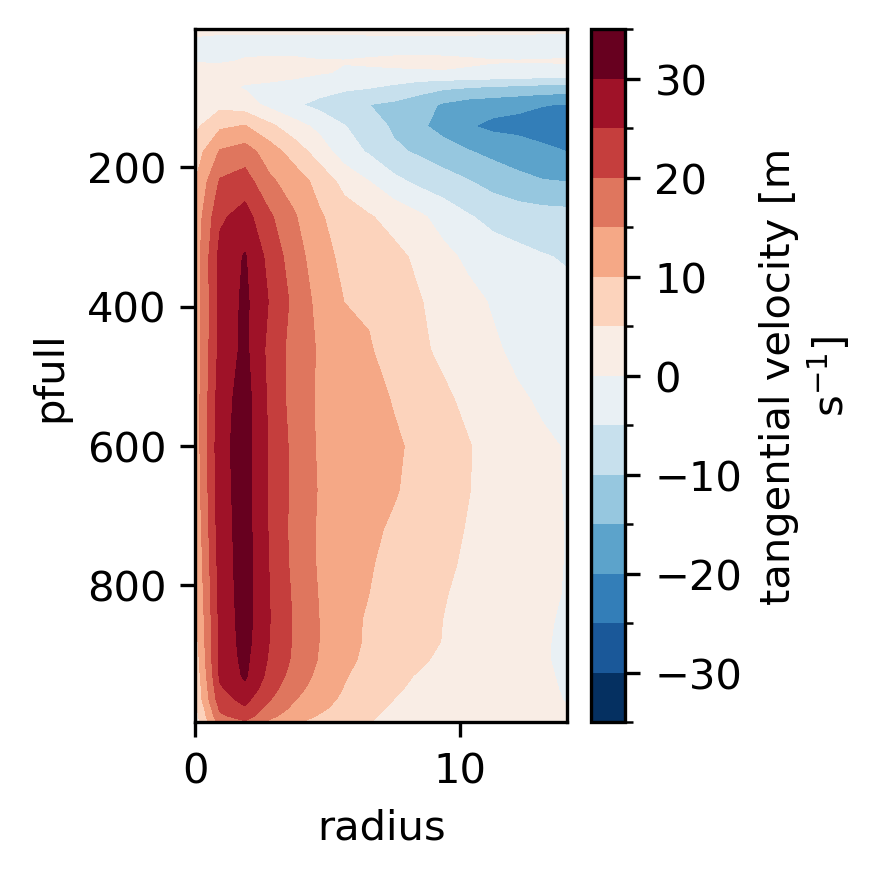

In [328]:
fig, ax = plt.subplots(figsize=(2, 3), dpi=300)
composite_azim.plot.contourf(levels=16, ax=ax)
ax.set_ylim(ax.get_ylim()[::-1])

Create diagnostic figure to show the annuli created

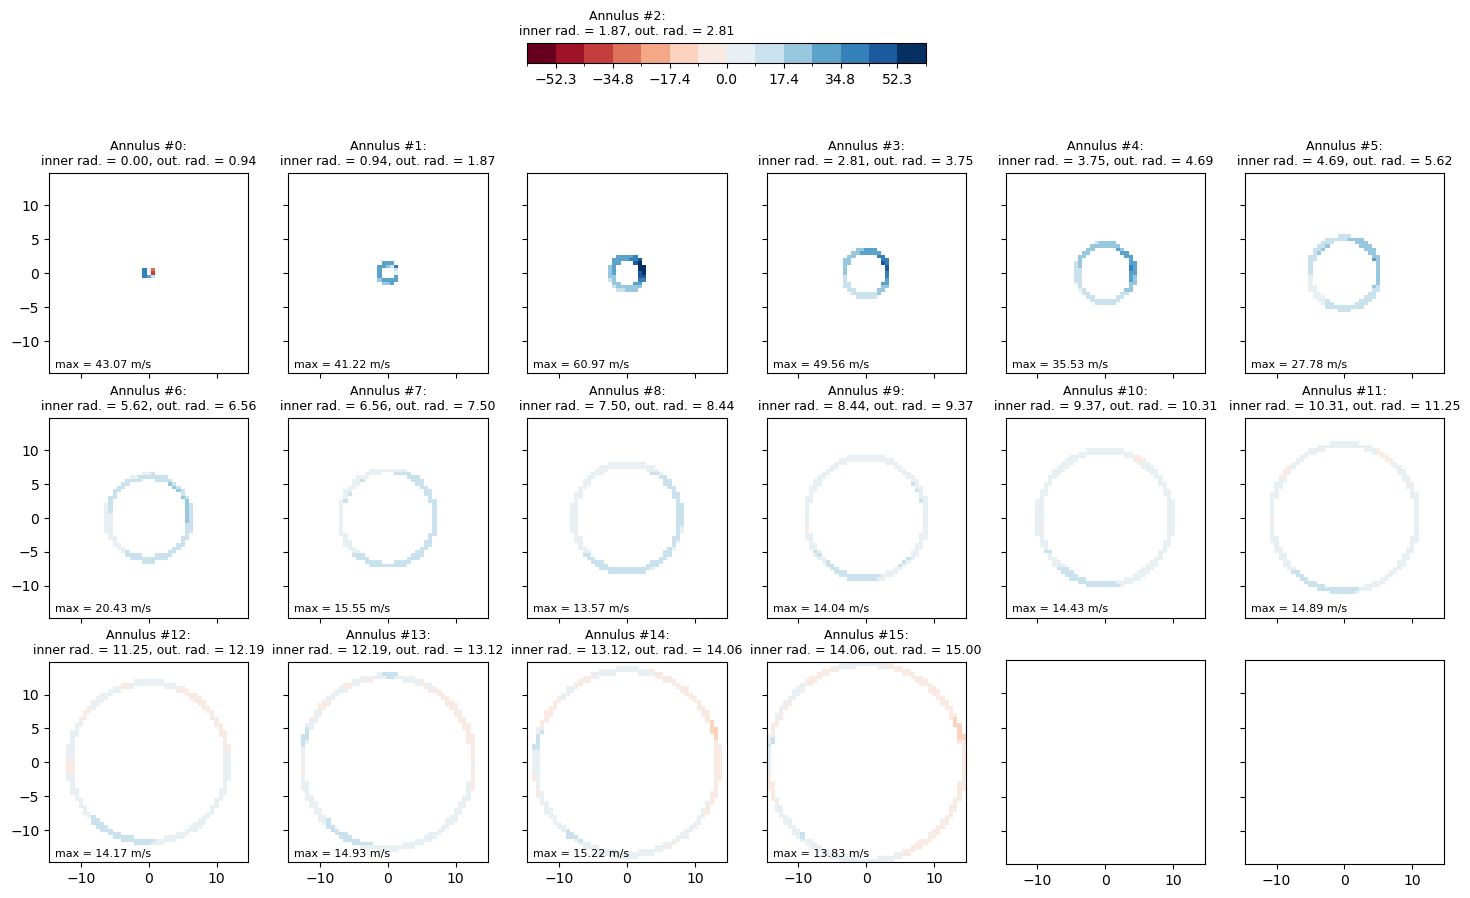

In [329]:
nrows = 3
ncols = int(np.ceil(len(visuals)/nrows))
fig, axes = plt.subplots(figsize=(ncols*3, nrows*3), nrows=nrows, ncols=ncols, sharex=True, sharey=True)

extremum = max([abs(min([v.min() for v in visuals.values()])), abs(max([v.max() for v in visuals.values()]))])
norm, cmap = matplotlib.colors.BoundaryNorm(np.linspace(-extremum, extremum, 15), 256), 'RdBu'

for index, item in enumerate(visuals.items()):
    ax = fig.axes[index]
    k, v = item
    ax.pcolormesh(v.TC_xt, v.TC_yt, v, norm=norm, cmap=cmap)
    ax.annotate('max = {0:.2f} m/s'.format(max([abs(v.min()), v.max()])), xy=(0.03, 0.03), xycoords='axes fraction', **{'fontsize': 8})
    ax.set_aspect('equal')
    ax.set_title(k, fontsize=9)

cax = fig.axes[2].inset_axes([0, 1.55, 2, 0.1])
colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')